#CHECKGPT DATASET (SAME AS THE ORIGINAL PAPER) WAS USED FOR FINE-TUNING AUTHORMIST

In [1]:
!git clone https://github.com/liuzey/CheckGPT-v2.git

Cloning into 'CheckGPT-v2'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 145 (delta 14), reused 29 (delta 9), pack-reused 107 (from 1)
Receiving objects: 100% (145/145), 1.10 GiB | 27.91 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (68/68), done.


In [2]:
!pip install datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

###Imports

In [9]:
from transformers import (pipeline, AutoTokenizer, AutoModel, AutoModelForCausalLM)
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import argparse
import gc
from datasets import Dataset
from trl import GRPOConfig, GRPOTrainer
from sklearn.model_selection import train_test_split
import json
import os
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig

In [10]:
# Clear memory at start
gc.collect()
torch.cuda.empty_cache()

### Preparing the dataset using CHECKGPT

In [11]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Function to create paraphrase prompt
def create_paraphrase_prompt(text: str) -> str:
    return f"""Please paraphrase the following text to make it more human-like while preserving the original meaning:
{text}
Paraphrased text:"""

# Load and prepare data
print("Loading data...")

# Load AI-generated texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/gpt.json', 'r') as f:
    gpt_data = json.load(f)
ai_texts = list(gpt_data.values())  # <-- fixed here

# Load Human-written texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/hum.json', 'r') as f:
    hum_data = json.load(f)
hum_texts = list(hum_data.values())  # <-- fixed here

# Limit dataset size to prevent OOM
max_samples = 300
if len(ai_texts) > max_samples:
    print(f"Limiting dataset to {max_samples} samples to prevent OOM")
    ai_texts = ai_texts[:max_samples]

# Split AI texts into train/test
train_texts, test_texts = train_test_split(ai_texts, test_size=0.2, random_state=42)

# Attach paraphrasing prompt to AI texts
train_texts = [create_paraphrase_prompt(text) for text in train_texts]
test_texts = [create_paraphrase_prompt(text) for text in test_texts]

# Create datasets
train_dataset = Dataset.from_dict({"prompt": train_texts})
test_dataset = Dataset.from_dict({"prompt": test_texts})

print(f"Training samples: {len(train_texts)}")

Loading data...
Limiting dataset to 300 samples to prevent OOM
Training samples: 240


### GRPO Config being setup along with PEFT

In [17]:
# Initialize the RADAR detector as None - will be loaded on first use
radar_detector = None

# Configure training with optimized settings for memory efficiency
print("Configuring training...")
training_args = GRPOConfig(
    output_dir="checkpoints/",
    logging_steps=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    fp16=True,
    optim="adamw_torch",
    gradient_checkpointing=True,
    max_grad_norm=0.5,
    remove_unused_columns=False,
    dataloader_num_workers=1,
    save_total_limit=1,
    save_strategy="epoch",
    eval_strategy="no",
    num_generations=2,
)

# Define PEFT configuration for LoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=128,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

Configuring training...


### RADAR and DetectGPT are used as detectors along with the SemanticSimilarityChecker

In [18]:
# Define multiple detector classes
class Radar():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading RADAR model...")
            self.judge_model = pipeline(
                "text-classification",
                model="TrustSafeAI/RADAR-Vicuna-7B",
                tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("RADAR model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "LABEL_0" else 1 - score["score"])
            for score in scores
        ]

# Add another detector class (example for an OpenAI-based detector)
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "1" else 1 - score["score"])
            for score in scores
        ]

# Add a semantic similarity checker
class SemanticSimilarityChecker():
    def __init__(self, device="cpu"):
        self.device = device
        self.model = None
        self.tokenizer = None

    def _load_model(self):
        if self.model is None:
            print("Loading Semantic Similarity model...")
            self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(self.device)
            self.tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
            print("Semantic Similarity model loaded successfully")

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embeddings(self, texts):
        self._load_model()
        encoded_input = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(self.device)
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        return self._mean_pooling(model_output, encoded_input['attention_mask'])

    def compute_similarity(self, original_texts, paraphrased_texts):
        # Get original texts from prompts (assuming prompt format is the same as in your code)
        extracted_originals = []
        for prompt in original_texts:
            text_start = prompt.find("following text:") + len("following text:")
            text_end = prompt.find("Paraphrased text:")
            extracted_originals.append(prompt[text_start:text_end].strip())

        original_embeddings = self.get_embeddings(extracted_originals)
        paraphrased_embeddings = self.get_embeddings(paraphrased_texts)

        # Compute cosine similarity
        similarities = []
        for i in range(len(original_embeddings)):
            similarity = F.cosine_similarity(original_embeddings[i].unsqueeze(0),
                                            paraphrased_embeddings[i].unsqueeze(0)).item()
            similarities.append(similarity)

        return similarities

# Initialize all detectors as None - will be loaded on first use
radar_detector = None
detectgpt_detector = None
semantic_checker = None

# Define a comprehensive reward function that combines multiple detectors
def multi_detector_reward_func(completions, prompts=None, **kwargs):
    global radar_detector, detectgpt_detector, semantic_checker

    # Initialize detectors if needed
    if radar_detector is None:
        radar_detector = Radar(device="cpu")
    if detectgpt_detector is None:
        detectgpt_detector = DetectGPT(device="cpu")
    if semantic_checker is None:
        semantic_checker = SemanticSimilarityChecker(device="cpu")

    # Process in smaller batches to reduce memory usage
    batch_size = 16
    all_rewards = []

    for i in range(0, len(completions), batch_size):
        batch_completions = completions[i:i+batch_size]
        batch_prompts = prompts[i:i+batch_size] if prompts else None

        # Get detector scores (lower is better - represents AI probability)
        radar_scores = radar_detector.score(batch_completions)
        detectgpt_scores = detectgpt_detector.score(batch_completions)

        # Calculate semantic similarity (higher is better)
        if prompts:
            semantic_scores = semantic_checker.compute_similarity(batch_prompts, batch_completions)
        else:
            semantic_scores = [1.0] * len(batch_completions)  # Default if no prompts

        # Calculate combined rewards
        for j in range(len(batch_completions)):
            # Detector rewards (higher is better - represents human-likeness)
            detector_reward = 0.5 * (1.0 - radar_scores[j]) + 0.5 * (1.0 - detectgpt_scores[j])

            # Semantic preservation reward (higher is better)
            semantic_reward = semantic_scores[j]

            combined_reward = 0.7 * detector_reward + 0.3 * semantic_reward

            all_rewards.append(combined_reward)

        # Clear memory after each batch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return all_rewards

# **Fine-tuning Authormist**

In [ ]:
!pip install -U bitsandbytes

In [19]:
# Load model for single-device training
print("Loading model...")
try:
    # Load the base model first
    model = AutoModelForCausalLM.from_pretrained(
        "authormist/authormist-originality",
        torch_dtype=torch.float16,
        device_map="auto",  # Keep this to automatically use available device
        load_in_8bit=True,  # Keep quantization for memory efficiency
        low_cpu_mem_usage=True
    )
    tokenizer = AutoTokenizer.from_pretrained("authormist/authormist-originality")

    # Apply LoRA adapters to the model
    print("Applying LoRA adapters to model...")
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    print("Model with LoRA adapters loaded successfully")

    # Initialize trainer without DeepSpeed
    print("Initializing trainer...")
    trainer = GRPOTrainer(
        model=model,
        reward_funcs=multi_detector_reward_func,
        args=training_args,
        train_dataset=train_dataset,
        processing_class=tokenizer,
        peft_config=peft_config,
    )

    print("Starting training...")
    trainer.train()

    print("Training completed successfully!")

except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Applying LoRA adapters to model...
trainable params: 29,933,568 || all params: 3,115,872,256 || trainable%: 0.9607
Model with LoRA adapters loaded successfully
Initializing trainer...


/usr/local/lib/python3.11/dist-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'authormist/authormist-originality' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Starting training...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Loading RADAR model...


Device set to use cpu


RADAR model loaded successfully
Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully
Loading Semantic Similarity model...
Semantic Similarity model loaded successfully


Step,Training Loss
3,0.000200
6,0.000300
9,0.000300
12,0.000300
15,0.000300


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Training completed successfully!


### Saving and loading the fine-tuned model

In [21]:
# First, save the model with its adapter configuration
output_dir = "fine-tuned-authormist"  # Use a different directory name without slash at the end
os.makedirs(output_dir, exist_ok=True)

# Save the LoRA model properly
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

# Now for merging, load the model correctly
try:
    # Load the base model
    base_model = AutoModelForCausalLM.from_pretrained(
        "authormist/authormist-originality",
        torch_dtype=torch.float16,
        device_map="auto",
        load_in_8bit=False  # Don't use 8-bit for saving
    )

    # Load the LoRA adapters from the saved directory
    merged_output_dir = "merged-authormist"
    os.makedirs(merged_output_dir, exist_ok=True)

    # Properly load the PEFT model
    model = PeftModel.from_pretrained(base_model, output_dir)

    # Merge the weights
    merged_model = model.merge_and_unload()

    # Save the merged model
    merged_model.save_pretrained(merged_output_dir)
    tokenizer.save_pretrained(merged_output_dir)

    print(f"Merged model saved to {merged_output_dir}")

except Exception as e:
    print(f"Error saving or merging model: {e}")
    import traceback
    traceback.print_exc()

Model and tokenizer saved to fine-tuned-authormist


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Merged model saved to merged-authormist


In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the merged model directly
model = AutoModelForCausalLM.from_pretrained(
    "merged-authormist",
    torch_dtype=torch.float16,
    device_map="auto"
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("merged-authormist")

# Set to evaluation mode
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), eps=1e-06)
    (rotary_emb):

## Getting AI and Human Generated text from our dataset

In [25]:
import json
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load AI-generated texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/gpt.json', 'r') as f:
    gpt_data = json.load(f)
ai_texts = list(gpt_data.values())  # <-- fixed here

# Load Human-written texts
with open('CheckGPT-v2/GPABenchmark/CS_TASK1/hum.json', 'r') as f:
    hum_data = json.load(f)
hum_texts = list(hum_data.values())  # <-- fixed here

In [26]:
hum_texts = hum_texts[:150]
ai_texts = ai_texts[:200]

## Loading AuthorMist (fine-tuned) as a Paraphraser for Testing

In [27]:
model_name = "merged-authormist"

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

# Set device to the first model device automatically
device = model.device

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
import csv
csv_filename = "paraphrased_results.csv"
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Original Text", "Paraphrased Text"])

    for i, ai_text in enumerate(tqdm(ai_texts[100:], desc="Paraphrasing texts")):
            prompt = f"""Please paraphrase the following text to make it more human-like while preserving the original meaning.
(Provide ONLY the paraphrased text with no additional commentary or responses)

{ai_text}

Paraphrased text:"""

            inputs = tokenizer(prompt, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.generate(
                    inputs.input_ids,
                    max_new_tokens=512,
                    temperature=0.7,
                    top_p=0.9,
                    do_sample=True
                )

            full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
            paraphrased_text = full_output.split("Paraphrased text:")[-1].strip()
            print(paraphrased_text)
            csv_writer.writerow([ai_text, paraphrased_text])
            del inputs, outputs
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"Paraphrasing complete! Results saved to {csv_filename}")

Paraphrasing texts:   0%|          | 0/100 [00:00<?, ?it/s]

This paper looks at Nash dynamics for markets where buyers and sellers need to be matched first in order to transact. Using game theory and models, we study when stable equilibrium is achieved in such markets and what causes instability. We also consider practical implications of results and discuss possible policy interventions to improve market performance. Ultimately this research stresses the significance of studying matching market dynamics to devise efficient and fair policies.


Paraphrasing texts:   2%|▏         | 2/100 [00:10<08:48,  5.40s/it]

This paper analyzes and evaluates communication infrastructure for wide area monitoring systems (WAMS) using 3G technology. The focus is on performance metrics such as reliability, scalability and efficiency. Literature review and experimental data are analyzed comprehensively. Results show that 3G communication infrastructure provides high reliability and efficiency for WAMS; however scalability is constrained by current network capacity. Conclusions state that this system works well for small to medium systems but will struggle to handle larger systems. Study findings provide important insight for people designing, deploying and optimizing communication infrastructure for WAMS.
This paper introduces a new method for indexing subgraphs in large graphs named Compact Neighborhood Index (CNI). CNI reduces storage space compared to existing indexes but also quickly processes queries. It represents neighborhoods of vertices compactly and uses a combination of hashing and bit operations to 

Paraphrasing texts:   3%|▎         | 3/100 [00:17<10:12,  6.32s/it]

This paper introduces a novel approach to language modeling using neural trans dimensional random fields. Through this framework, different kinds of data sources are flexibly combined and processed efficiently. In particular, the proposed method makes use of neural networks to extract features from input data and incorporates these into the random field model. This model captures complex relationships between words and sentences and is useful for tasks such as generation of language, machine translation, and sentiment analysis. Results obtained on benchmark data sets demonstrate effectiveness of the proposed approach; performance is higher than that of leading models such as recurrent neural nets and transformers in terms of both accuracy and efficiency. Furthermore, the model also excels at generalization. Thus the model handles both out of distribution data and noisy data well. Overall, this paper presents a new view on language modeling by integrating neural networks and trans dimen

Paraphrasing texts:   4%|▍         | 4/100 [00:28<12:36,  7.88s/it]

The deployment of 5th generation wireless communication systems is essential for diverse applications such as IoT, autonomous vehicles, and smart cities. For maximum benefit, we need fast, low latency and reliable connectivity. One promising way to achieve this is by using millimeter wave (mm wave) frequencies. However, propagation characteristics of mm wave differ significantly from lower frequency waves and this poses significant design and deployment challenges for 5G networks. This paper conducts an experiment to study propagation characteristics in small scales, local areas and transitional environments at 28 GHz. Using a custom built mm wave test bed, the authors measured channel parameters like path loss, delay spread and angular spread in various scenarios including clear line of sight (LOS), not clear line of sight (NLOS) and transitional environments. Results indicate that propagation characteristics depend strongly on specific environment and scenario and that customized ant

Paraphrasing texts:   5%|▌         | 5/100 [00:41<15:23,  9.72s/it]

This paper looks into economic factors that cause vulnerability and exploitation in today's society. By integrating perspectives from economics, sociology and politics, this study focuses on the roles of power dynamics, globalization and neoliberal policies in shaping patterns of vulnerability and exploitation. Beginning with a look at vulnerability itself, we investigate how things like poverty, unemployment and insecure employment contribute to both individuals and groups. Then we examine mechanisms of trade and exploitation, focusing on how globalization and corporations based across borders exploit vulnerable people in the South. We also analyze how neoliberal policies worsen vulnerability and exploitation. These policies like deregulation, privatization and austerity erode labor protections and social safety nets making those who are already vulnerable even more likely to be exploited. In conclusion, we discuss possible paths to addressing these economic factors leading to vulnera

Paraphrasing texts:   6%|▌         | 6/100 [00:52<15:58, 10.20s/it]

This paper introduces a novel approach for inferring social connections based on individual movement profiles which it calls "walk2friends". The authors use GPS data to derive movement patterns of people to identify and forecast social ties among them. They test this method using real mobility traces and social network connections from a university campus. Detailed descriptions are given about preprocessing GPS data, constructing profiles of movement and applying a machine learning algorithm to predict ties. Comparisons are made against other methods for inferring social ties and results show that this method excels both in accuracy and speed. Also discussed is an extensive analysis of what influences tie prediction using mobility data such as time and space resolution, proximity and frequency of contacts and mobility patterns of individuals. Results of this research are significant and suggest that walk2 friends performs well for diverse applications including targeting marketing and 

Paraphrasing texts:   7%|▋         | 7/100 [01:02<15:33, 10.04s/it]

This paper reports an investigation into applying reinforcement learning specifically Q learning to Black Scholes and Black Scholes Merton financial models. A Q learner is called QLBS and is used to optimize portfolio management and also to assess performance of the proposed solution against traditional approaches. Results show that QLBS performs better than traditional methods in terms of portfolio returns and risk management. Insights are gained into potential uses of reinforcement learning in finance and the significance of considering changing market conditions in portfolio management. Findings from this research advance development of sophisticated financial decision making systems and are important practically for investors and portfolio managers.


Paraphrasing texts:   8%|▊         | 8/100 [01:08<13:36,  8.88s/it]

This paper looks at improving exploration using Evolution Strategies for Deep Reinforcement Learning. Authors introduce a new method that uses a population of agents who seek novelty to enhance searching through the space of search. These agents learn to find new states and actions; they use these results to guide evolution of the main population of learning agents. Results from different benchmark environments show that this approach is superior to traditional Evolution Strategies regarding efficiency with samples and asymptotic performance. Results indicate that adding a population of novelty seekers greatly enhances the exploration process in Evolution Strategies for Deep Reinforcement Learning.


Paraphrasing texts:   9%|▉         | 9/100 [01:14<12:04,  7.96s/it]

This paper investigates how to use machine learning and topological data analysis to distinguish chatter patterns during turning operations. Turning operations often suffer from chatter which leads to poor surface finish, tool wear and damage to both machine tools and work pieces. The purpose here is to develop a good system for recognizing chatter that will help detect and diagnose chatter. We collect vibration signals during turning operations and transform these signals into time frequency representations through wavelet transforms. Then we analyze the resulting images using topological data analysis; this lets us extract topological features and patterns that describe different types of chatter. Using support vector machines and random forests we train machine learning algorithms on extracted features for chatter classification. Performance is measured with metrics like accuracy, precision and recall. Results show that the proposed method correctly classifies different types of cha

Paraphrasing texts:  10%|█         | 10/100 [01:26<13:51,  9.24s/it]

Using fuzzing is becoming more popular for finding previously unknown flaws in software. Traditionally, fuzzing relies on randomly generating tests that often generate irrelevant test cases that don't reveal new flaws. This paper proposes an innovative way to enhance effectiveness of fuzzing by integrating metrics related to software complexity. We introduce specific complexity metrics like code complexity and flow and data complexity and incorporate those into the fuzzing process. We use these metrics to direct generation of test cases focusing on parts of software that are likely to have flaws. We evaluated this approach on various open source programs known to have vulnerabilities. Results show that this method greatly improves effectiveness by reducing irrelevant test cases and finding more new flaws. We compared against other leading fuzzing methods as well and consistently perform better at detecting flaws. Overall, we demonstrate that incorporating software complexity metrics in

Paraphrasing texts:  11%|█         | 11/100 [01:36<13:59,  9.44s/it]

This paper introduces a new way to access secondary spectrum with constraints related to Signal to Interference plus Noise Ratio (SINR). Based on transforming these constraints, this method allows more efficient use of spectrum resources. Results of simulations comparing to traditional methods show significant improvement in serving users and spectrum efficiency. Results indicate this approach can be deployed in practice. The work also offers important ideas for those who study spectrum management and opens possibilities for future research into optimizing access to spectrum with SINR.


Paraphrasing texts:  12%|█▏        | 12/100 [01:41<11:58,  8.16s/it]

This paper introduces an improved bound on subpacketization that applies to minimum storage regenerating codes. MSR codes are codes designed for distributed storage systems to protect against failures and ensure reliable access to data stored at different locations. By refining the analysis of how subpackets are allocated, this new bound outperforms previous ones. It is tighter and more accurate; this means better design efficiency for MSR codes can be achieved. Numerical simulations support the theoretical results and show clear advantages of this new bound in practice. Improvements to the bound contribute importantly to distributed storage system design and could result in more efficient implementations of such systems.


Paraphrasing texts:  13%|█▎        | 13/100 [01:48<11:08,  7.69s/it]

This paper introduces a new method to scale up heuristic planning by integrating Relational Decision Trees (RDTs). Heuristic planning excels at solving practical problems; however, performance diminishes when problems are too complicated or search spaces grow too large. RDTs offer a way to enhance scalability through improved search efficiency and effectiveness. Proposed method uses RDTs to model relationships among states and guides search. They are learned from a set of training examples via a decision tree learning algorithm, capturing complex relationships hidden from simple heuristics. These trees are used to select promising branches of the search tree based on learned relationships. Results show that using RDTs greatly enhances scalability and performance especially on domains with large search spaces and complex state relationships. Performance also surpasses many leading algorithms on most domains. Thus the approach promises to improve scalability and performance of heuristic 

Paraphrasing texts:  14%|█▍        | 14/100 [01:57<11:43,  8.18s/it]

This paper investigates how crowdsourcing might work as a way to collect content for serious games focused on scenarios. Serious games have grown increasingly important for education in different fields like healthcare, business and military training. However, creating realistic and engaging scenarios requires much time and resources. Using crowdsourcing seems promising because it taps into the combined intelligence and creativity of many people. The paper studies a case where crowdsourcing is used to gather content for a serious game that teaches conflict resolution skills to medical students. Mixed methods are used; quantitative data collection is done alongside qualitative feedback review from users of the game. Results show high quality crowd generated content enhances effectiveness as a learning tool. Challenges include careful moderation and effective communication with contributors. Overall this paper offers important insight into whether crowdsourcing can produce quality conten

Paraphrasing texts:  15%|█▌        | 15/100 [02:07<12:15,  8.66s/it]

This paper introduces Snsapi, a cross platform middleware designed to rapidly deploy decentralized social networks. Decentralization contrasts with centralized networks aiming to mitigate privacy, security and censorship concerns. But deploying decentralized networks is hard because it involves diverse skills like coding, sys admin, networking. Snsapi seeks to simplify this by providing a high level API that hides technical details. The authors detail the design and implementation of Snsapi which relies on modular architecture allowing easy expansion and customisation. Support includes protocols such as Diaspora, Mastodon and ActivityPub. Core features include authentication, content management and node communication which can be added via plugins. Performance evaluation shows low overhead relative to underlying protocols and scalability for many users and nodes. Overall Snsapi is a strong tool for developers aiming to deploy decentralized networks requiring little technical background

Paraphrasing texts:  16%|█▌        | 16/100 [02:16<12:26,  8.89s/it]

This paper looks at designing mechanisms that maximize auction revenues. Quasi proportional auctions are frequently employed in industries like telecom and transport. These auctions involve different budgets and valuations among bidders. The paper introduces a new mechanism that considers both bidders' budgets and valuations and also ensures high auctioneer revenue. Results from simulation tests show this new mechanism performs better than other mechanisms known in the literature. Conclusions drawn include practical implications on mechanism design.


Paraphrasing texts:  17%|█▋        | 17/100 [02:21<10:36,  7.67s/it]

This paper looks into different types of failures in ML systems and how they affect result accuracy and reliability. First the paper defines what failures mean for ML systems, such as over fitting and under fitting along with bias in data. It then systematically studies common failures and identifies underlying causes and suggests detection and mitigation methods. Results show that system failures can seriously hurt result quality and reliability and point out that rigorous monitoring and evaluation of these systems is important. At the end the paper offers suggestions for further research and practical use of ML in industry.


Paraphrasing texts:  18%|█▊        | 18/100 [02:27<09:39,  7.07s/it]

This paper introduces a new micro architecture for decoders that are robust against faults for quantum computing. The proposed design aims to solve issues faced by present systems such as large scale correction of errors, high computational costs, and limited scalability. Decoding micro architecture relies on a new method of quantum error correction using many parallel decoder units for efficient and scalable correction. It also incorporates a mechanism for fault tolerance to reduce adverse impacts from hardware errors and to assure stability and reliability of quantum computation. Results from simulations and tests show significant benefits including scalability and reduction of computational overhead over existing solutions. Proposed architecture is anticipated to be key for enabling large systems of quantum computing and furthering progress in quantum technology.


Paraphrasing texts:  19%|█▉        | 19/100 [02:34<09:35,  7.11s/it]

Stable view synthesis is critical for computer vision and graphics and concerns creation of new viewpoints from given sets of images. The goal is to produce high quality results which faithfully represent the true geometry and appearance of the scene. This work reviews recent advances in stable view synthesis including both older and newer methods. Authors assess advantages and disadvantages of different approaches and compare performance against multiple datasets and benchmark tests. Challenges and future directions are also discussed such as integration of deep learning, management of complex and dynamic scenes and development of interactive and real time systems. In summary, this paper is important for researchers and practitioners; it points out how synthesis of stable views is important across many domains.


Paraphrasing texts:  20%|██        | 20/100 [02:41<09:25,  7.07s/it]

This paper investigates again the technique of removing elements for density based structural optimization using Heaviside projection method. This method allows reintroducing removed elements to design and mitigates the problems of high density and low density experienced by traditional approaches. Results show that the new approach yields better optimization results compared to previous ones; designs are thus more efficient and effective.


Paraphrasing texts:  21%|██        | 21/100 [02:45<08:02,  6.11s/it]

This paper reviews critically recent research using randomized machine learning to predict output of renewable energy. It introduces current best methods and points out their shortcomings and ways they might be improved. Results and new views on applying randomized learning to this field are also described and debated. Authors examine advantages and disadvantages of different randomized approaches and suggest new avenues of future work. At the end there is consideration of implications of this research for designing better and more efficient prediction systems for renewables.


Paraphrasing texts:  22%|██▏       | 22/100 [02:50<07:29,  5.76s/it]

Convolutional Neural Opacity Radiance Fields (CNORF) is a deep learning technique used to solve the radiance transfer problem caused by atmospheric scattering. In this paper we introduce an improved version of CNORF that uses a convolutional neural network to predict radiance fields from scene geometry and atmospheric conditions. This network is trained using a large set of synthetic scenes and performs well on real ones. Results indicate that this new method outperforms leading techniques both in terms of accuracy and efficiency. This new approach opens up new avenues for remote sensing and rendering scattering effects in real time.


Paraphrasing texts:  23%|██▎       | 23/100 [02:56<07:36,  5.92s/it]

This paper looks at uniformity within diversity specifically in the context of crowd counting. It focuses on count intervals and seeks to thoroughly analyze different methods for partitioning those intervals along with their pros and cons. Research also investigates the effect that different ways of partitioning count intervals have on accuracy of counting people and offers guidance on balancing consistency and diversity in this area. Results of this study are important for developing better counting systems and also offer deep insights into the intricacies involved.


Paraphrasing texts:  24%|██▍       | 24/100 [03:01<07:10,  5.67s/it]

This paper introduces a new method for anticipating future actions from first person perspectives. Anticipation of actions considers prediction of upcoming actions of a person based on previous actions and is hard because human actions are unpredictable and dynamic. We combine computer vision and machine learning to analyze and anticipate actions in real time using egocentric video streams. The system processes video data continuously and anticipates actions as they happen. Performance of this approach is assessed on various benchmark datasets and compared against leading methods. Results show good performance and suggest potential applications including human computing interactions, robotics and analysis of sports.


Paraphrasing texts:  25%|██▌       | 25/100 [03:07<07:13,  5.78s/it]

This paper introduces a framework that uses models for safe reinforcement learning for intelligent vehicles which take into account time varying states and controls. The new method combines MPC and reinforcement learning to reconcile exploration and exploitation and guarantees safety. Results from simulations show this new approach excels at safety maintenance alongside performance enhancement compared to standard MPC and RL methods. This research brings forward an encouraging resolution for efficient and safe decision making in systems with changing constraints.


Paraphrasing texts:  26%|██▌       | 26/100 [03:12<06:41,  5.43s/it]

This paper looks into using Bayesian optimization to optimize both the structure and parameters of function networks. These networks are mathematical constructs that model complicated relationships between inputs and outputs. Optimization of these networks is tricky because one needs to find the best mix of structure and parameters that minimizes prediction errors against real data. Bayesian optimization is a probabilistic method for global optimization that has proven useful in different areas such as machine learning. In this work, authors introduce an approach based on Bayesian optimization for optimizing function networks and test their approach on diverse benchmark problems. Results indicate that compared to traditional optimization techniques this new approach performs better and delivers reliable solutions for optimizing networks.


Paraphrasing texts:  27%|██▋       | 27/100 [03:19<07:05,  5.83s/it]

Ramsey's theorem is a key result in combinatorics that guarantees the existence of monochromatic cliques in properly colored graphs. We here report on two extensions of this theorem that extend the foundational result. The first extension studies cliques of a certain fixed size; the second extends the notion of coloring to hypergraphs. Both extensions explore deeper into the nature and existence of such cliques within graphs and hypergraphs. Results from this work contribute greatly to research in combinatorics and applications of Ramsey theory.


Paraphrasing texts:  28%|██▊       | 28/100 [03:24<06:52,  5.72s/it]

This paper studies how to estimate mixing time using just one sample trajectory of reversible Markov chains. Authors introduce a novel way to estimate mixing time which does not rely on many sample trajectories or knowing the stationary distribution. They base their approach on statistical analysis of convergence towards the stationary distribution. Results are compared to other methods using several examples and they show that this proposed method produces high accuracy mixing time estimations and is more efficient as well. Conclusion is that this method is valuable for analysis of mixing time for reversible Markov chains.


Paraphrasing texts:  29%|██▉       | 29/100 [03:30<06:43,  5.69s/it]

This research examines rationality in security decision making from the perspective of dancing pigs and externalities. The aim is to study how decision makers strike a balance between security and competing interests such as cost and public image. By using both quantitative and qualitative methods, this paper measures how much decisions rely on rational thinking or are shaped by extrinsic factors such as media coverage or public pressure. Results show that practical security decisions are usually affected by a mix of rational and irrational factors and decision makers need to carefully weigh the possible external consequences of their actions. At the end the study suggests ways to enhance rationality in security decisions given these challenges.


Paraphrasing texts:  30%|███       | 30/100 [03:36<06:58,  5.99s/it]

This paper evaluates comprehensively the security of mail distribution systems. It looks at various kinds of systems, from traditional physical mail delivery to newer digital ones. The paper looks into different security threats like unauthorized access, data theft, and tampering. Also examined closely are current security methods including encryption, authentication and access controls. Results show current security measures can reduce certain risks but further improvements are needed. Authors suggest best practices to improve system security and give suggestions for future research in this field. Insights here are useful for people and organizations who depend on secure and dependable mail distribution systems.


Paraphrasing texts:  31%|███       | 31/100 [03:42<06:56,  6.03s/it]

This paper introduces a new method for designing controllers with maximum lifespan under unreliable communications. It uses decentralized control methods which factor in communication limitations and possible failure occurrence to achieve both stability and optimality in large scale networked control systems. Proposed approach combines control networking with control theory to build a comprehensive design framework that is resilient to communication disruptions. Numerical simulation results show effectiveness at high performance levels despite unreliable communication.


Paraphrasing texts:  32%|███▏      | 32/100 [03:47<06:17,  5.54s/it]

This paper studies the stability of structural equation models (SEMs) for causal inference. SEMs are commonly used to study complicated systems and infer causal relations between variables. Stability and robustness under errors in measurement and unobserved variables are important factors that must be taken into account. Results of careful investigation into stability under different conditions like different sample sizes and measurement error as well as unobserved variables show that SEMs can be unstable under certain circumstances; moreover, effects from measurement error and unobserved variables are also quite significant. This paper's findings are important for the validity and reliability of SEMs for causal inference and suggest guidelines for further research.


Paraphrasing texts:  33%|███▎      | 33/100 [03:54<06:38,  5.95s/it]

In this paper we introduce an efficient framework for performing amortized Bayesian inference for complex hierarchical and nonlinear dynamic systems. We base our framework on variational inference and use data structure and patterns to reduce computational burden. Using amortization we are able to efficiently approximate posterior distributions of system parameters and states. Performance of this framework is evaluated against diverse challenging real datasets and results indicate that this approach captures underlying structure and patterns effectively while offering substantial computational savings over traditional Bayesian inference methods. Results of this research have significant implications for analysis of complicated systems and may lead to new understanding and insights into such systems.


Paraphrasing texts:  34%|███▍      | 34/100 [04:00<06:38,  6.03s/it]

This paper introduces a new approach to generate scalable and realistic recommendation datasets using fractal expansion. Based on the inherent fractal nature of interaction between users and items this new method exploits the self similarity property of fractals to create synthetic data that closely resembles actual recommendation scenarios. In order to evaluate effectiveness, we compare performance of leading algorithms on both synthetic and real data sets. Results show that expanded fractal data shares similar statistical characteristics with real world data; they also perform better in scalability and efficiency to produce larger scales of recommendation data. Further study investigates effects of different expansion parameters on generated data and provides guidance on choosing suitable parameters for different recommendation contexts. Limitations and potential improvements are also discussed, including incorporation of temporal aspects and user feedback into the expansion procedur

Paraphrasing texts:  35%|███▌      | 35/100 [04:09<07:29,  6.91s/it]

This paper examines effectiveness of three distinct information distribution policies: elitism, egalitarianism and welfarism on enhancing performance in task oriented teams. Results from experiments involving human participants show that both elitism and egalitarianism outperform welfare. Performance improvement by elitism is highest; under this approach information is given to top performers. Distribution of information equally to all members resulted in better performance compared to welfare which allocates to those who need it most. Results point towards policies that emphasize performance of individuals over needs being superior for teams. Practical importance for organizations aiming at improving team performance and for policy makers designing allocation of information for group context follow from these results.


Paraphrasing texts:  36%|███▌      | 36/100 [04:16<07:24,  6.94s/it]

This paper introduces an algorithm for parallel weighted random sampling of large datasets. Weighted random sampling is frequently used in statistics, machine learning, and mining data where samples are drawn proportional to their weights. The authors design this algorithm to take advantage of modern multicore processors and distributed computing systems to achieve high performance and scalability. The algorithm builds upon reservoir sampling which keeps a reservoir of fixed size and randomly replaces reservoir contents based on weights. Parallelization uses splitting the data into small subsets and applying reservoir sampling independently to each subset. Further optimization is done by balancing load dynamically to reduce communication overhead and improve workload distribution. Results from both synthetic and real data show that parallel algorithm has significant performance improvement and scales well as dataset size increases and number of computing nodes rises. Compared against o

Paraphrasing texts:  37%|███▋      | 37/100 [04:27<08:30,  8.10s/it]

This paper looks at how to use Bayesian heat maps to do probabilistic classification when there are multiple data sources that are unreliable. Usually heatmap classification assumes that data is clean and reliable, but in practice this is rarely the case. We propose using a Bayesian framework to model uncertainty in the data and classify probabilistically taking reliability into account. Performance is tested on both synthetic and real data sets and results show that our approach excels over standard classification methods especially if data is noisy or inaccurate. Results also show effects of different priors and hyper parameters and discuss some possible application areas like image processing and remote sensing as well as medical diagnosis.


Paraphrasing texts:  38%|███▊      | 38/100 [04:33<07:54,  7.66s/it]

Quantization bias has been recognized as an important problem that reduces performance of machine learning models. This paper seeks to solve this issue by proposing a new way of dealing with bias through using bias itself. The proposed method introduces a bias term into quantization process and thereby reducing quantization error and improving model performance. Results of experiments conducted on different datasets and models demonstrate that the proposed approach significantly reduces quantization bias and improves accuracy compared to existing quantization methods. In addition, this research also sheds light on tradeoffs between quantization errors and bias and stresses the significance of balancing both aspects during quantization. Findings from this research are significant for practical deployment of machine learning models in constrained resources.


Paraphrasing texts:  39%|███▉      | 39/100 [04:41<07:39,  7.53s/it]

This study examines the Filter Early, Match Late (FEML) method for improving visual place recognition through networks (VPR). In this method, a filtering step reduces the number of images that must be compared during the matching phase. Training a convolutional neural network predicts likelihood of pairs of images being matches. Then filtered images are compared using descriptor matching algorithms. Performance of the method is evaluated using the challenging RobotCar Seasons data set and results in strong improvement over previous methods. Experiments also show robustness to changes in lighting conditions, weather and seasons. The paper also explains details of the FEML method and finds that learned filters emphasize specific regions like road edges and building facades which are important for VPR. Insights into mechanism underlying this approach are provided. Overall, this research shows effectiveness of FEML method for improving VPR based on network and provides important insights i

Paraphrasing texts:  40%|████      | 40/100 [04:50<08:00,  8.01s/it]

This study looks into creating smart city IoT services through large scale collaboration. With growing demand for smart city services, integration of IoT has become necessary to provide higher efficiency and sustainability. Implementation however is complex and requires collaboration from different parties like government, businesses and academia. Study looked at challenges and opportunities of large collaboration in service creation. Results show that collaboration is key to overcoming technical, organizational and regulatory hurdles that block smart city implementations. Results indicate collaboration improves efficiency and effectiveness and accelerates development of new services that meet citizen needs. Insights are offered for policy makers, academics and practitioners working on smart IoT city services. Findings stress need to develop effective collaboration mechanisms and promote sharing of open data. Privacy and security concerns are also addressed. Initiatives must consider p

Paraphrasing texts:  41%|████      | 41/100 [04:58<07:55,  8.06s/it]

This study looks at current situations regarding artificial intelligence and the efforts underway toward responsible development and deployment. It begins by defining responsible AI and core principles such as transparency, accountability, fairness and ethics. Then authors survey current situation and challenges involved like lack of clear guidelines and regulations, need for diverse viewpoints and stakeholder engagement and the complexity involved in actual implementation of responsible AI. It also analyzes roles of different actors such as government, companies and academia in promoting responsible AI. Authors look at current initiatives and best practices such as development of ethical frameworks, creation of ethics committees for AI and embedding ethics in AI curriculum. Finally the paper emphasizes that responsible AI is important and that there needs to be continued collaboration and action from all parties. Authors urge development of clear enforceable standards and embedding et

Paraphrasing texts:  42%|████▏     | 42/100 [05:07<08:04,  8.35s/it]

This paper introduces a new approach for generating realistic facial expressions in 3D based on adversarial learning and dense guidance of geometry. The method makes use of spatial relationships among facial landmarks and expression to direct synthesis toward better results; this contrasts with prior work that relies only on appearance features. An adversarial component drives synthesis towards matching the distribution of real expressions, resulting in outcomes that look more natural and credible. Results of quantitative and qualitative evaluations show the method excels at realism and consistency with input geometry; results suggest great potential for diverse uses such as graphics, vision and HCI.


Paraphrasing texts:  43%|████▎     | 43/100 [05:13<07:19,  7.71s/it]

This paper introduces a new deep learning system called uvid-net that improves segmentation accuracy in videos captured by UAVs. Recent use of UAVs for diverse tasks such as mapping and environmental monitoring has brought challenges, particularly related to segmentation where distinguishing pixels into classes is important. Utilizing temporal cues embedded in UAV videos, uvid-net takes advantage of 3D convolutional neural networks to capture spatial and temporal features from video frames. These features are processed using a feature pyramid network to generate high-level feature maps and decoded to produce a final segmentation map. Results on two public datasets show that this method performs better compared to leading approaches especially for hard distinction classes like cars and buildings. Results indicate that this work promises an effective approach for segmentation of UAV aerial videos. Incorporation of time information using 3D CNNs greatly improves segmentation accuracy whic

Paraphrasing texts:  44%|████▍     | 44/100 [05:22<07:37,  8.18s/it]

This paper introduces an organized way of developing industrial specific languages (DSLs). The proposed approach includes four critical steps: domain analysis, language design, language development and deployment. During the step of domain analysis, both domain experts and language developers work together to pinpoint specific concepts and corresponding language features. Language features are defined using a higher level language and are checked against certain quality standards in language design. Then the language features are translated into executable code during development. Finally, the developed DSL is integrated into the targeted environment and performance is evaluated. Results from application of this approach in various industrial contexts show effectiveness at producing high quality and efficient DSLs.


Paraphrasing texts:  45%|████▌     | 45/100 [05:29<07:06,  7.76s/it]

This paper introduces a pipeline using machine learning for automatic extraction of statistical reports and experimental conditions from scientific papers. The pipeline comprises three main parts: first there is a preprocessing step that clears and organizes raw text from papers; second, there is a module that identifies and extracts reports of statistics from processed text; and third comes a module that retrieves experimental conditions related to identified statistics. The pipeline performance has been tested on a data set of papers and performs well with high precision and recall on both statistical reports and experimental conditions. Proposed pipeline facilitates automation of important information extraction from papers thus enhancing efficiency of scientific research.


Paraphrasing texts:  46%|████▌     | 46/100 [05:36<06:37,  7.37s/it]

This paper introduces a new approach to reliably detecting compressed and encrypted data. Detection challenges arise frequently; for example, identifying malware in network traffic and locating sensitive information in digital forensics. Current methods are often inaccurate, inefficient, or specialized to certain kinds of compression or encryption. Here, we introduce a method using machine learning which combines feature extraction and classification to reliably detect such data. Our method successfully identifies a broad variety of compression and encryption techniques, including those that have not been reported before. Results are evaluated on varied datasets and compared favorably against leading current methods with respect to both detection accuracy and computational performance. Overall our approach is flexible and straightforward to integrate into systems that look for malicious or sensitive information.


Paraphrasing texts:  47%|████▋     | 47/100 [05:43<06:32,  7.41s/it]

This paper investigates vulnerabilities in ML systems related to attacks on resizing images and suggests a new way to defend against these attacks. Resizing attacks involve manipulating image sizes and resolutions to deceive ML systems into misclassifying them. The paper looks at vulnerabilities that can be exploited in such attacks like dependency vulnerability of inputs, gradient masking and inversion attacks. It then introduces a new defensive mechanism that adds carefully designed adversarial samples to the input data to prevent attacks from succeeding. Effectiveness is demonstrated through experiments using benchmarks of datasets showing its success in resisting various attacks on resized images. In summary, this research stresses the importance of considering vulnerabilities together in ML systems and offers a new defense that mitigates impacts of resizing attacks.


Paraphrasing texts:  48%|████▊     | 48/100 [05:51<06:25,  7.42s/it]

This paper explores how to use graph prediction methods to forecast relationships among human traits and genes. Human traits are observable physical or biochemical features of people; genes code for these traits. The connection between traits and genes frequently turns out to be complicated and hard to predict. Understanding this association better might yield important clues regarding disease development and treatment. Using data from public databases such as gene trait associations and protein interactions, a heterogeneous graph is built. Different graph prediction methods like those based on node similarity, paths, and matrix factorization are then used to project new links among traits and genes. Performance of different methods is assessed using cross validation and other standard metrics. Results indicate that graph prediction methods work well at projecting new links between traits and genes; performance improves when combining methods. Overall, this study shows promise for usin

Paraphrasing texts:  49%|████▉     | 49/100 [06:01<07:09,  8.42s/it]

This paper looks into video object segmentation: identifying an interesting object in a video sequence. We introduce a new approach that links objects with transformers, a common type of neural net architecture used for natural language processing. Our approach uses a two stage process. First, we apply a conventional object detector to identify objects in each frame. Then we link each identified object to a transformer network which learns appearance and motion information through time. The transformer outputs feature embeddings that serve as input to a fully convolutional network for generating pixel level segmentation masks. We test this method on different benchmark datasets and compare it against leading approaches. Results indicate significant improvements by linking objects with transformers; our results are among best on various datasets. Overall we propose a promising new approach to segmentation that integrates strength from both traditional vision and modern neural nets.


Paraphrasing texts:  50%|█████     | 50/100 [06:10<06:59,  8.40s/it]

This paper proposes an approach for designing strategies using learning methods for use with robots to support reminiscence therapy for people suffering from dementia. Proposed approach involves a newly built model that focuses on enhancing therapeutic quality by means of personalized and interactive sessions. Model considers current cognitive and emotional states of the person, prior life experiences and preferred communication style. Strategy design uses machine learning algorithms to process data and adjust therapy sessions in real time; this results in tailored and effective treatment. Results from a feasibility study show that proposed approach works effectively and improves general wellbeing and cognitive and emotional states of patients. Results have significant implications for design and deployment of robotic reminiscence therapy and show promise of learning approaches in delivering personalized care for those with dementia.


Paraphrasing texts:  51%|█████     | 51/100 [06:17<06:39,  8.16s/it]

This research looks at the hidden practices involved in managing data within large facilities. It focuses on an important firm that manages facilities. Often we think about data curation as something technical but here we highlight that there are also important social and organizational aspects to data curation. Interviews and observations show there are diverse ways to handle data such as using informal communication channels, creating ad hoc tools and procedures, and embedding data into decision making. Results show that these hidden practices are key to managing facilities well but they are usually neglected or not valued enough. At the end the work suggests suggestions for facility managers to help them better support and appreciate these hidden data curation practices.


Paraphrasing texts:  52%|█████▏    | 52/100 [06:24<06:14,  7.80s/it]

Over many years researchers have studied tractability of Constraint Satisfaction Problems (CSPs). This paper investigates tractability of CSPs defined by forbidden patterns. First we introduce forbidden pattern as a set of constraints that does not occur together in any solution. We define a class of CSPs based on such patterns and study their computational complexity. We find that some CSPs defined by forbidden patterns are easy to compute; other ones are NP hard. Particularly we identify a large subset that can be solved in polynomial time regardless of the number of variables. Furthermore we observe that complexity of CSPs defined by forbidden patterns correlates closely with the structure of these forbidden patterns themselves. Results from this work are significant for designing and analyzing algorithms for solving CSPs; they suggest that pattern structure may guide algorithm design and reveal types of patterns that make solving difficult. Benchmarks designed for testing CSP solve

Paraphrasing texts:  53%|█████▎    | 53/100 [06:34<06:28,  8.27s/it]

Embedding capacity of information flows is an important parameter for communication networks that specifies the maximal amount of data that can be sent without errors. This paper examines this capacity for flows subject to renewal traffic patterns, where inter arrival times between successive packets follow distributions that vary over time. Based on a theoretical framework derived from queueing theory, we derive analytical expressions for different channel types under this traffic regime. Results show that capacity depends strongly on statistical characteristics of inter arrival time distributions and can behave unexpectedly like decreasing with higher arrival rates or diverging in certain parameter ranges. We also study effects of key system parameters such as capacity levels, noise, and packet size on embedding capacity. Numerical results indicate significant enhancement through coding schemes that take advantage of temporal structures in renewal traffic. This work adds to fundament

Paraphrasing texts:  54%|█████▍    | 54/100 [06:44<06:49,  8.91s/it]

This study looks at distributed estimation and learning on networks where nodes vary in resource level, communication capability and measurement quality. Key task is to develop methods that enable nodes to work together and estimate an unknown parameter based on their own data. Major difficulty is the heterogeneity among nodes; they have varying levels of processing power, communication capacity and measurement performance. Algorithms proposed here balance tradeoffs among computational cost, communication cost and estimation accuracy. Both theoretically and experimentally the new methods are examined and demonstrated to perform well across many network types. Results from this work contribute knowledge about designing efficient and effective algorithms for distributed estimation and learning in heterogeneous networks; these findings could be useful for applications like wireless sensor networks, machine learning and robotics.


Paraphrasing texts:  55%|█████▌    | 55/100 [06:52<06:22,  8.51s/it]

This research paper looks into how heteroscedasticity affects classifier design in Linear Discriminant Analysis (LDA). LDA is commonly used for classification but typically assumes equal variance among classes which is not usually true in practice. When this assumption is violated, classifier performance can suffer. This paper introduces a new approach to LDA which accounts for heteroscedasticity through use of a weighted covariance matrix in the discriminant function. Performance comparisons between this approach and traditional LDA are made using both simulated and real data at varying levels of heteroscedasticity. Results from simulations show that the proposed method performs better than traditional methods if variances among predictors vary between classes. Performance improvement also occurs in classification of real data sets that exhibit heteroscedasticity. Methods are also developed to choose the best weighting scheme to maximize classification accuracy. Results indicate that 

Paraphrasing texts:  56%|█████▌    | 56/100 [07:02<06:36,  9.02s/it]

This paper looks into using serverless protocols for inventory and tracking with unmanned aerial vehicles (UAVs). It introduces a framework for an inventory and tracking system that allows UAVs to collect inventory data in real time autonomously and send data to a remote server using serverless protocols. The system includes UAVs fitted with sensors, local storage modules and wireless communication devices. Data collection occurs along a predefined route by the UAVs and data is transmitted remotely to a server. Advantages and drawbacks of this proposed system are also discussed such as enhanced security of data, low latency and scalability. Results from simulation and experiments show feasibility and effectiveness of this serverless inventory and tracking system. Findings suggest that using serverless protocols can be a feasible solution for inventory and tracking through UAVs; offering increased security, efficiency and scalability for data handling and transmission.


Paraphrasing texts:  57%|█████▋    | 57/100 [07:11<06:24,  8.94s/it]

In this paper, authors suggest using deep learning approaches to optimize auction mechanisms for managing resources at the edge in mobile blockchains. They note that current allocation mechanisms are not efficient and neglect important dynamic aspects of mobile devices and network conditions. To tackle this they introduce a deep reinforcement learning framework that considers different things like congestion levels, mobility of devices and resource availability for making optimal resource allocations. Results of simulations comparing this new approach against traditional auction methods show significant improvements in resource utilization and reduction in latency and better overall network performance. Research indicates deep learning has great potential to transform resource management in mobile blockchains and opens avenues for future research.


Paraphrasing texts:  58%|█████▊    | 58/100 [07:17<05:47,  8.27s/it]

This paper introduces a new training method called Viser for deep neural networks. Viser adds an extra branch to the network that learns to reconstruct images. This branch serves as a regularizer that discourages deviations from the original input image. Results indicate this regularization leads to improved generalization performance on different classification benchmarks. Analysis also shows that Viser encourages learning important and discriminating features.


Paraphrasing texts:  59%|█████▉    | 59/100 [07:21<04:49,  7.05s/it]

This paper investigates stochastic gradient methods for online optimization. Often, projections are needed but this is difficult and costly when dealing with high dimensional spaces. The paper introduces a new algorithm which applies stochastic gradients to optimize convex and sub modular functions. It provides theoretical assurances about convergence and effectiveness of the proposed approach. Results show the algorithm performs well and efficiently on diverse optimization tasks. Results also indicate this new method might offer an interesting alternative to typical online optimization approaches that require projection.


Paraphrasing texts:  60%|██████    | 60/100 [07:27<04:18,  6.45s/it]

This paper looks at controlling a system of heavily loaded queues with different classes, called $m / m / n + m$, within the Halfin-Whitt regime. Such systems are very busy and so performance is measured over a long time. The aim is to develop a control strategy that minimizes long run average costs and ensures stability. We formulate this as a Markov Decision Process (MDP) and use dynamic programming principles to obtain an optimal control policy. We also present a heuristic policy which is simple to use and requires little computation. Performance is evaluated numerically comparing against the optimal policy; simulations show the heuristic performs near optimally and outperforms many common policies. Finally we discuss implications and offer guidance on designing controls for such systems. Conclusions highlight contributions made and point towards further research directions.


Paraphrasing texts:  61%|██████    | 61/100 [07:35<04:34,  7.05s/it]

This paper studies incidence coloring for graphs that are highly connected. We measure connectivity through a parameter called Maximum Average Degree (MAD). Incidence coloring assigns distinct colors to both vertices and edges such that no two incident elements share a color. This subject has important applications including in graph theory, computer science, and communications. We focus on finding precise upper limits for the incidence chromatic number of such graphs. We use a variety of techniques including decomposition of graphs and algebraic methods for analysis. We study the relation between MAD and chromatic number. Results shed new light on coloring behaviors for highly connected graphs and also contribute towards better solving algorithms for incidence coloring.


Paraphrasing texts:  62%|██████▏   | 62/100 [07:42<04:26,  7.02s/it]

Autoscaling is becoming increasingly important for cloud services because they need to handle different user needs. Traditional methods use fixed scaling rules which don't work very well for the rapidly changing nature of clouds. This paper compares two new ways of doing autoscaling: one that learns from past data (self aware) and another that uses control theory (self adaptive). We used an application running in the cloud and compared performance of these two new methods against traditional ones. Results show both learn better and respond faster to reduce delays and use resources more efficiently. Adaptive ones are also much better at dealing with big surges in demand, while learners do better for long term resource usage trends. Overall, this research shows advantages of these self aware and adaptive methods and points out their relative merits. We think these approaches can improve resource management by cloud providers and reduce cost from over provisioning.


Paraphrasing texts:  63%|██████▎   | 63/100 [07:51<04:40,  7.58s/it]

This paper examines allocation of locally generated electricity in renewable communities. We analyze current means of energy distribution as well as obstacles these communities encounter related to storage and distribution. Research also investigates potential for distributed systems where energy production and consumption occur within the same community. These systems can improve energy efficiency and decrease reliance on traditional grids. The paper also looks at governmental policies and regulation and the advantages renewable communities may bring, including higher energy security, reduction of carbon emissions and stronger local economies. Results indicate that renewable communities have strong potential to transform energy landscape towards a more sustainable future but also stress importance of effective policies and regulations to support growth and development of these communities.


Paraphrasing texts:  64%|██████▍   | 64/100 [07:58<04:25,  7.37s/it]

This paper looks at how academic and social groups communicate differently during pandemics. It compares how each group shares information and finds out what influences their preference for communication. Results show significant differences regarding source selection, detail level needed and preferred methods. Results of this research should help policymakers and communicators to better grasp different community needs and to design more targeted communication approaches.


Paraphrasing texts:  65%|██████▌   | 65/100 [08:02<03:42,  6.37s/it]

This paper introduces a new approach to predicting Remaining Useful Life (RUL) of Hard Disk Drives (HDDs) by using Bidirectional Long Short Term Memory (LSTM) networks. Historical operation data is used to train a deep learning model which predicts RUL for specific HDDs. Bidirectional LSTMs are selected due to their capability to process past and future context from sequential data. Results show this new method performs better than current best methods on accuracy and reliability. This work contributes importantly to predictive maintenance for HDDs and shows promise for RUL estimation via deep learning.


Paraphrasing texts:  66%|██████▌   | 66/100 [08:08<03:35,  6.33s/it]

We introduce an extension of nonextensive theory into economics and consider possible applications of this idea to model economic systems. Incorporating ideas from this statistical framework allows us to include heterogeneity and long range correlations present in economic data. This contrasts with conventional economic models which typically overlook these features. Results indicate that this kind of model better captures the dynamics of real economic systems and could be used to refine policy decisions in a finer and more effective way. In summary then, this research emphasizes the significance of using nonextensive statistical mechanics in economics and shows promise for improving understanding of complex economic systems.


Paraphrasing texts:  67%|██████▋   | 67/100 [08:14<03:28,  6.31s/it]

This paper introduces a new online approach for dynamic resource allocation of networks. We address this by using algorithms that learn in real time and adapt to changing and unpredictable demands. The core idea uses convex optimization theory and applies online algorithms to get near optimal decisions for resource allocation. Performance evaluation is done via extensive simulation; results show the proposed method excels in resource usage and system efficiency over standard allocation methods. This new approach promises to greatly enhance performance in situations where networks are highly dynamic and rapidly varying.


Paraphrasing texts:  68%|██████▊   | 68/100 [08:20<03:12,  6.02s/it]

This paper introduces Frauddroid, a new system for automatic detection of ad fraud targeting Android apps. Using machine learning methods, Frauddroid monitors app behavior in real time and detects unusual activity that points to fraudulent activities. Designed to be both effective and efficient, Frauddroid reduces the time and effort needed for manual detection of fraud. Experimental results show high accuracy in detecting fraud with very low false positives. This system has great potential to greatly improve security within the Android ecosystem and shield advertisers from financial loss through fraud.


Paraphrasing texts:  69%|██████▉   | 69/100 [08:25<03:02,  5.89s/it]

This paper introduces a method for understanding trace timing in real time for partially synchronous systems. Authors look at communication and process execution and propose techniques for capturing and visualizing trace data. Results reveal insights into dynamic system behavior which are important for debugging and performance analysis. Evaluation using real systems demonstrates effectiveness in clearly comprehending system behavior and this study advances research into distributed systems and suggests new tools for monitoring and analysis of such systems.


Paraphrasing texts:  70%|███████   | 70/100 [08:30<02:45,  5.50s/it]

This paper introduces a new method for automatic segmentation of 3D volume data from retinal optical coherence tomography (OCT). It uses an enhancement algorithm to boost quality of boundaries surfaces. Segmentation is based on these enhanced surfaces. Results show this method produces high accuracy and reliability for segmenting retinal tissues. This new tool helps in analysis and interpretation of disease. This work advances development of advanced retinal imaging methods and holds promise for better diagnosis and treatment of retinal diseases.


Paraphrasing texts:  71%|███████   | 71/100 [08:35<02:37,  5.44s/it]

This study concentrates on applying ordinary differential equations (ODE) to Markov Decision Processes (MDPs) and exploiting them for optimizing costs measured by the Kullback-Leibler divergence (KL). The paper looks at an extensive review of ODE methods for solving MDPs and points out both advantages and drawbacks when compared to conventional approaches like dynamic programming. Results also show that ODE methods are effective and accurate especially if KL cost is an important criterion. Conclusions draw attention to implications for control theory and decision making and suggest new lines of inquiry. Numerical simulations are used to substantiate findings.


Paraphrasing texts:  72%|███████▏  | 72/100 [08:42<02:40,  5.74s/it]

This work investigates transmit beamforming for exploiting interference within Cognitive Radio systems operating on Z channels. The main goal is to design and implement an algorithm that maximizes effectiveness at exploiting interference in cognitive radios. This algorithm uses a mix of game theory and optimization methods; its aim is to enhance system performance by optimizing signal transmission amidst interference. Results from simulations and experiments indicate that proposed algorithm performs much better than others and it greatly improves capacity and reliability. Research results suggest that transmit beamforming could be a key tool for enhancing performance of such systems.


Paraphrasing texts:  73%|███████▎  | 73/100 [08:47<02:34,  5.74s/it]

This paper introduces a new way to combine evidence from lots of different sources to get better decisions that are both precise and reliable. This method considers variability and uncertainty within each single source and uses a mathematical system to combine the evidence systematically. Results of many simulation studies indicate this new method works much better compared to previous approaches, especially for large sets of sources. Broad applicability is found across many different areas including diagnosis in medicine, recommendation systems, and sensor network fusion.


Paraphrasing texts:  74%|███████▍  | 74/100 [08:52<02:23,  5.52s/it]

This paper introduces an innovative adversarially trained Normalized Auto Encoder with Noise (ANNAE) for text generation. Using a mix of adversarial training and normalization methods, ANNAE improves quality of generated text. Proposed model combines benefits of auto encoders and adds a noise layer into encoding process to generate high diversity and robust representation of input data as well. Additionally, normalization methods are used to improve stability and convergence during training. Results from different benchmarks show that ANNAE excels in both quality and diversity of generated text compared to top performing models.


Paraphrasing texts:  75%|███████▌  | 75/100 [08:58<02:21,  5.67s/it]

This paper proposes an innovative method for improving speech recognition in robots through mimicking binaural localization of sound sources using biological inspiration. The authors want to develop a more human sounding auditory system for robots so they can better distinguish speech in loud or confusing environments. Using two microphones like human ears, they localize sounds and filter out background noise to focus on the targeted speech. Results show significant improvement over previous monaural methods. Authors conclude that this new approach is promising as a breakthrough for speech recognition technology and might result in further development of better and more human like robots.


Paraphrasing texts:  76%|███████▌  | 76/100 [09:04<02:19,  5.80s/it]

Chest X-rays are important for detecting lung diseases but their low resolution makes it hard to see smaller lung structures. This paper introduces a deep learning approach for enhancing visibility of lung features on chest X rays. We use fully convolutional neural networks (FCNN) trained using a large set of X rays and corresponding CT scans. The model learns to predict CT values at every pixel and thus transforms low resolution X ray images into high resolution ones. Resulting enhanced images clearly show improvements in visibility of small features such as nodules and blood vessels. Results show that our approach using FCNNs effectively enhances visibility of lung features and could increase accuracy of disease diagnosis.


Paraphrasing texts:  77%|███████▋  | 77/100 [09:11<02:21,  6.13s/it]

This paper reports on discussions at the Workshop on Social Robots for Therapy. This event gathered people from different fields such as robotics, psychology and ethics. They talked about possible advantages and disadvantages of using social robots in therapy. Themes discussed include development of clear ethical guidelines for therapy use of robots; designing robots that enhance user autonomy; and consideration of how robots will affect the relationship between therapist and patient. At the end there was an appeal for continued collaboration among disciplines and research to assure that therapy robots are both safe and effective.


Paraphrasing texts:  78%|███████▊  | 78/100 [09:17<02:11,  5.97s/it]

This paper introduces a new method called Panoptic Fusion for volumetric semantic mapping of the web. This method considers both 'stuff' and 'things'. Panoptic Fusion fuses information from a 3D LiDAR sensor with semantic information from 2D RGB images into one dense representation of the environment. Novel fusion uses probability framework to integrate different types of data. Results are highly accurate and rich semantically; this enables efficient decision making for robotics. Comprehensive evaluation is performed on diverse indoor and outdoor settings and shows that Panoptic Fusion excels compared to leading approaches. Results indicate high performance for segmentation of semantic classes and reconstruction of 3D structure. Promising results suggest Panoptic Fusion holds great promise for enhancing perception in practical situations.


Paraphrasing texts:  79%|███████▉  | 79/100 [09:25<02:17,  6.53s/it]

This paper introduces an efficient preconditioner for large scale nuclear simulations that solves the neutron transport equation using scalable multilevel domain decomposition. The authors use an algorithm based on subspaces for constructing a hierarchy of nested subdomains which capture important physics. They incorporate adaptive thresholding into this algorithm to enhance refinement. Results show that this preconditioner reduces the number of solver iterations substantially, leading to faster and higher quality solutions. Performance and scalability are demonstrated with experiments on a variety of practical test cases involving cores of reactors having millions of degrees of freedom. Results indicate very good parallel efficiency and this approach works effectively to solve large scale neutron transport problems efficiently and accurately on high performance computers.


Paraphrasing texts:  80%|████████  | 80/100 [09:32<02:13,  6.68s/it]

This paper introduces a new method for learning Lie algebras using unlabelled data pairs. Learning Lie algebras from data has received much attention in mathematics; however, previous approaches rely on labelled data or strong assumptions regarding Lie algebra structure. Here we present an innovative algorithm which uses deep neural networks to learn Lie algebras from data without relying on labels or strong assumptions. Our method combines unsupervised and supervised learning to learn Lie algebra structure and performs evaluations on various datasets to show effectiveness. Results show that our approach performs better both in terms of accuracy and efficiency compared to other methods and it has potential applications in diverse areas like computer graphics and robotics where learning Lie algebras is required.


Paraphrasing texts:  81%|████████  | 81/100 [09:39<02:11,  6.92s/it]

This paper introduces a new approach for learning to reflect and beamforming through use of smart reflecting surfaces (IRS). The authors use deep neural networks (DNNs) to simultaneously estimate channels and direct signals toward desired direction. Training is performed end to end with respect to minimizing mean squared error between desired and received signal. Unlike conventional approaches, this method doesn't require explicit channel estimation and handles a broader range of channel models. Results show the approach performs better than others in terms of performance accuracy and resilience to channel uncertainty. Results also suggest this work opens up new ways of deploying IRS in practical communication systems and will spur future research on designing DNN based IRSs.


Paraphrasing texts:  82%|████████▏ | 82/100 [09:46<02:05,  6.95s/it]

This paper investigates performance of language tools on 15 officially under resourced languages of the EU. It looks at effectiveness of tools in four main tasks: POS tagging, named entity recognition, dependency parsing and machine translation. Results are compared using various evaluation metrics across different tasks and languages. Results show that tool effectiveness varies across languages and tasks. Areas requiring further development of language tools are also identified. Findings from this research benefit policymakers and researchers focused on language technology especially for under resourced languages. Contributions of this research also include advancement and evaluation of tools for under resource languages which matters for linguistic diversity preservation and promotion of multilingualism within the EU.


Paraphrasing texts:  83%|████████▎ | 83/100 [09:53<01:57,  6.93s/it]

Cutting edge research is being conducted on Dynamic Neural Garments which combines wearable tech with advanced ML algorithms. The goal is to develop next generation smart clothes which can adjust in real time to the wearer's body and surroundings. This paper provides a detailed survey of current leading research in this area and highlights recent developments for creation of these garments. Authors review different ways to make them such as using sensors, actuators and ML algorithms. Challenges and constraints that need to be overcome are also discussed. Potential application areas and future directions are also addressed at the conclusion.


Paraphrasing texts:  84%|████████▍ | 84/100 [09:59<01:45,  6.62s/it]

This paper introduces a new algorithm named PromiPS designed for fast approximate searches in high dimensions. It focuses on finding near neighbors in high dimensional vector spaces which are difficult because of rapid increase in search space. PromiPS uses a lightweight index to quickly query efficiently while reducing storage use. PromiPS uses a strategy of dividing and conquering to split high dimensions into smaller subspaces which can be queried more effectively. It also includes probabilistic pruning to reduce number of dot products needed. Results show that PromiPS excels compared to leading methods in both speed and index size; for example, it can achieve up to ten times faster and hundred times smaller indexes under certain conditions. Scalability is also demonstrated and it performs well with big data sets. Overall this work contributes significantly to high dimension nearest neighbor search with both high accuracy and low cost. Using a light weight index structure is importa

Paraphrasing texts:  85%|████████▌ | 85/100 [10:09<01:53,  7.58s/it]

The rise of popularity of electric vehicles has led to an increase in charging station installations. However, this also increases risk of cyber attack, specifically ransomware. Ransomware can shut down these charging stations leading to inconvenience for EV owners. This paper proposes a method based on deep learning for detecting ransomware in Supervisory Control And Data Acquisition (SCADA) systems of charging stations. We use CNN to analyze network traffic from SCADA systems and identify suspicious patterns. We use a simulated dataset containing both ransomware and normal traffic for experimental evaluation. Results indicate that this proposed method accurately detects attacks and outperforms other machine learning approaches. This approach may be used as a tool to quickly detect attacks and reduce their effects on EV users.


Paraphrasing texts:  86%|████████▌ | 86/100 [10:17<01:46,  7.62s/it]

This paper looks at how to use Bayesian deep learning methods to address the high need for timely and personalized instructor response in forums of Massive Open Online Courses (MOOCs). MOOCs have grown very popular lately because they are accessible and flexible. But the large number of students enrolling in MOOCs makes it hard for teachers to respond quickly and personalize feedback especially on forums where students ask questions and seek help. Proposed solution uses deep learning models to identify urgent questions requiring immediate intervention by teachers. These models take into account things like question nature, time since posting and student expression of urgency. By including these factors in the model, it can recognize which questions require immediate attention allowing teachers to give priority to responses. Research used data from a popular MOOC platform and compared the proposed solution to other approaches. Results show this Bayesian deep learning model excels in bot

Paraphrasing texts:  87%|████████▋ | 87/100 [10:28<01:54,  8.81s/it]

This paper presents a new benchmark dataset for question answering specific to electronic devices and develops a framework using multitask learning. This dataset contains a diverse collection of questions and answers about devices such as smartphones and laptops as well as other consumer electronics. A framework leveraging common knowledge and shared representations across diverse tasks is designed and implemented. Experiments test the performance of this framework on the benchmark dataset and results show significant improvement compared to previous methods in terms of both accuracy and efficiency. Results also reveal strengths and weaknesses of this framework. Contribution of this work includes development of a new benchmark dataset for QA on electronics along with a novel framework for different types of QA tasks.


Paraphrasing texts:  88%|████████▊ | 88/100 [10:35<01:38,  8.24s/it]

This paper introduces a new approach for training automatic planners for cardiac MR imaging by leveraging relationships among different views using unsupervised learning. The authors address the problem of collecting large amounts of labeled data needed for supervised learning and the shortcomings of unsupervised methods which depend on predefined selection criteria. The core of this new method includes three main components: a selection component, a synthesis component and an evaluation component. Selection component selects candidate views based on spatial relationships between current and adjacent views. Synthesis component synthesizes images for selected candidates through use of generative models. Evaluation component evaluates synthesized images with a discriminator network and selects high quality views. Experiments on public datasets have demonstrated effectiveness of this new method relative to leading unsupervised approaches: they show higher quality images and better selecti

Paraphrasing texts:  89%|████████▉ | 89/100 [10:46<01:40,  9.11s/it]

This paper looks at relationships among logics and games related to true concurrency and aims to develop a broad framework for reasoning about concurrent systems. First we introduce true concurrency as the capability of systems to run different processes simultaneously. We review existing models of concurrency and discuss their advantages and disadvantages. Then we introduce a new framework that combines logic and game theory ideas. This framework uses logic based on bisimulation and shows how logic can be used to reason about behavior of concurrent systems. We also introduce a new game theoretic model for concurrency and show how this allows us to analyze strategic interaction among agents within concurrent systems. Results are shown through case studies such as distributed and multi agent systems. These results indicate effectiveness of our new framework for dealing with complex concurrent systems. In summary, this paper offers a novel and comprehensive framework that integrates idea

Paraphrasing texts:  90%|█████████ | 90/100 [10:56<01:34,  9.43s/it]

This paper introduces a new method of matching posterior probabilities for Gaussian Multiple Access Channels (GMACs) with feedback. Compared to previous decoding methods this new approach improves achievable rate regions. Using this new method codewords from different users are matched to channel outputs and use feedback to improve alignment. There is also a quantization step to reduce feedback rate. The authors derive theoretical analysis of rate regions for their proposed method and show it performs better than other decoding approaches. Simulations confirm effectiveness of this scheme in practice. Proposed method using posterior matching along with feedback promises high performance gains for GMAC communications.


Paraphrasing texts:  91%|█████████ | 91/100 [11:03<01:16,  8.50s/it]

This paper investigates effectiveness of Tree Memory Networks (TMNs) as an instrument for modeling long dependencies in sequential data. Traditional neural nets struggle to handle complex long dependencies because of their limited memory capacity. TMNs are recursive networks that can express long dependencies hierarchically. Performance is compared between TMNs and traditional nets on various sequential data tasks including processing natural language and generating music. TMNs excel at capturing long dependencies and perform at high levels. We examine interpretability of TMNs through visualization of learned hierarchy showing meaningful linguistic and musical features consistent with human intuition. Finally we discuss possible application areas like understanding natural language, speech recognition and time series analysis. Results indicate that TMNs show promise for modeling long dependencies and shed light on mechanisms of long term memory processing.


Paraphrasing texts:  92%|█████████▏| 92/100 [11:11<01:06,  8.33s/it]

This paper introduces a hybrid transfer network designed to learn shared representations among different types of data including text, images, and audio. The proposed architecture combines unsupervised and supervised learning to address the challenge of aligning diverse data types into a single shared space while retaining important characteristics from each type. An encoder based on cross modal autoencoders is used for unsupervised learning and a classifier is used to improve discriminative power. Results obtained using benchmark datasets show this hybrid network outperforms leading methods in retrieval and classification. In conclusion, the authors assert that their network can facilitate effective integration of different types of information and will be useful for future tasks like recommendation and cross modal searching.


Paraphrasing texts:  93%|█████████▎| 93/100 [11:18<00:55,  7.98s/it]

This paper introduces Cryptoguard which is a tool for pinpointing high precision vulnerabilities in very large Java projects. Security is important for data protection, yet cryptography itself can introduce problems if used incorrectly. With today's large codebases, manual identification and resolution of such issues is difficult. Cryptoguard uses static analysis techniques to automatically find misuse of cryptographic APIs such as employing weak algorithms or inappropriate key sizes. Based on best practice and standard guidelines, it sets up a rule set to mark probable vulnerabilities. Designed to be highly accurate, Cryptoguard avoids false positives and reports only genuine vulnerabilities. Evaluation of Cryptoguard on datasets of 12 prominent open source Java projects shows effectiveness at high precision in detecting vulnerabilities. Results indicate that Cryptoguard detects flaws that other similar tools miss and finds both known and previously undiscovered ones too. In summary, 

Paraphrasing texts:  94%|█████████▍| 94/100 [11:28<00:52,  8.75s/it]

This paper studies how to minimize Age of Information (AoI) using energy harvesters that update erasures either with or without feedback. AoI is a measure of freshness of transmitted data. We focus on a situation where there are limited energy resources and we rely on harvesting energy from the environment to do our updates. We also experience erasures that result in losing information and therefore increasing AoI. Comparisons are made between two situations: one with feedback where we get information about our update statuses and one without feedback where we don't know the status of our updates. Results show that receiving feedback improves AoI performance of energy harvester significantly in situations with erasure. Results are important for designing efficient communication systems that need to keep data fresh.


Paraphrasing texts:  95%|█████████▌| 95/100 [11:36<00:42,  8.46s/it]

This paper reports proceedings of a combined meeting of the 25th International Workshop on Expressiveness in Concurrent Systems and the 15th Workshop on Structural Operational Semantics. At this joint meeting leading experts in theoretical computer science gathered to report recent progress and new advances concerning concurrency and operational semantics. The goal of the meeting was to offer an opportunity for researchers to share ideas, display latest results and participate in discussions that could guide future research. It summarizes key themes and subjects discussed at the meeting such as expressive modeling of concurrency, development of new techniques for operational semantics and practical application of those techniques to actual systems. Also it points out some promising new directions that have emerged from the meeting and suggests further work in this area.


Paraphrasing texts:  96%|█████████▌| 96/100 [11:44<00:32,  8.20s/it]

This paper introduces the design and testing of "Odys" which is a parallel search engine that uses an integrated database management system (DBMS) along with techniques of database informed information retrieval (DBIR). The study addresses scalability and efficiency issues of traditional search engines through integration of DBMS and IR into one system. Performance evaluation is carried out on large data sets and Odys is compared against top search engines. Results show significant improvements in processing queries and retrieving information. This work advances research by showing integration of DBIR for large scale search application to be feasible and advantageous.


Paraphrasing texts:  97%|█████████▋| 97/100 [11:50<00:22,  7.58s/it]

This paper investigates relationships between q entropies and a type of generalized Fisher information. Q entropies generalize classical Shannon entropy and have been applied in various disciplines like statistical mechanics, information theory and signal processing. Generalized Fisher information characterizes information content in a distribution related to an important parameter. The paper derives a Cramér Rao inequality involving q entropy and generalized Fisher information that bounds variance of any unbiased estimator of interesting parameter by derivative of q entropy against this parameter. Bounds are derived for a wide class of distributions and this result leads to lower bounds on variance of unbiased estimators. Results are relevant to designing and analyzing statistical inference methods across different areas.


Paraphrasing texts:  98%|█████████▊| 98/100 [11:57<00:14,  7.39s/it]

This paper studies coordinated beamforming in dense wireless cooperative networks where high data rates and energy efficiency are essential goals. We introduce an algorithm that coordinates transmissions from multiple base stations and users efficiently and reduces interference. This new method makes use of channel matrix sparsity and channel statistics to jointly optimize beamforming vectors and power allocation among cooperating nodes. Distributed implementation allows this approach to scale well to large networks. Performance evaluation was done using simulations across diverse network conditions like varying densities of users and antennas. Results show that this new algorithm outperforms other advanced methods especially in dense networks. In summary, this proposed algorithm offers scalable and effective solutions to coordinated beamforming problems for future wireless communications systems.


Paraphrasing texts:  99%|█████████▉| 99/100 [12:04<00:07,  7.31s/it]

Recently there has been a big increase in demand for wireless communication services and this has caused a shortage of radio spectrum. As one way to solve this problem, spectrum sharing allows different service providers to share the same frequency band. However, there are many technical and economic problems related to sharing spectrum like interference and coordination costs. To deal with these issues some countries have introduced subsidy regulation that gives money to companies who take part in sharing spectrum. The purpose of this paper is to look at how subsidy regulation impacts sharing incentives. Through reviewing literature the paper identifies different types of subsidy regulation and their goals. It also analyses how different subsidy mechanisms affect sharing incentives such as levels of subsidies, allocation criteria and subsidy duration. Results show that subsidy regulations can effectively motivate sharing by lowering coordination costs and enhancing benefits of sharing

Paraphrasing texts: 100%|██████████| 100/100 [12:16<00:00,  7.37s/it]

Paraphrasing complete! Results saved to paraphrased_results.csv


# DETECTION

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import random
from transformers import (pipeline, AutoTokenizer, AutoModel, T5ForConditionalGeneration, T5Tokenizer, AutoModelForCausalLM)

In [30]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

In [31]:
qd = pd.read_csv('paraphrased_results.csv')
qd_texts = qd['Paraphrased Text'].tolist()

ai_data = {'text': qd_texts, 'label': 1, 'source': 'AI'}
human_data = {'text': hum_texts, 'label': 0, 'source': 'Human'}

ai_df = pd.DataFrame(ai_data)
human_df = pd.DataFrame(human_data)
combined_df = pd.concat([ai_df, human_df], ignore_index=True)
random.seed(42)
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_df.to_csv('combined_texts.csv', index=False)

print("Data preparation complete. Saved to 'combined_texts.csv'")

Data preparation complete. Saved to 'combined_texts.csv'


### RADAR - getting scores

In [32]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [
            (
                score["score"]
                if score["label"] == "LABEL_0"
                else 1 - score["score"]
            )
            for score in scores
        ]

### DETECTGPT - getting scores

In [33]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [
            (score["score"] if score["label"] == "1" else 1 - score["score"])
            for score in scores
        ]

In [34]:
df = pd.read_csv('combined_texts.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [35]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('combined_texts.csv')
combined_df['detectgpt_score'] = scores_detectgpt
combined_df['radar_score'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

Device set to use cuda


Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully


In [36]:
combined_df.head()

,text,label,source,detectgpt_score,radar_score
0,Attempt to fully discover the temporal diversi...,0,Human,0.001085,0.020639
1,This paper introduces a novel approach for inf...,1,AI,0.000397,0.017593
2,This paper investigates relationships between ...,1,AI,0.000447,0.048453
3,This paper looks at controlling a system of he...,1,AI,0.000345,0.011821
4,MIMO processing plays a central part towards t...,0,Human,0.000879,0.009042


### RADAR - getting labels

In [47]:
class Radar():
    def __init__(self, device="cuda"):
        self.judge_model = pipeline(
            "text-classification",
            model="TrustSafeAI/RADAR-Vicuna-7B",
            tokenizer="TrustSafeAI/RADAR-Vicuna-7B",
            max_length=512,
            padding='max_length',
            truncation=True,
            device=device,
        )

    def score(self, response_list):
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

### DetectGPT - getting labels

In [48]:
class DetectGPT():
    def __init__(self, device="cpu"):
        self.device = device
        self.judge_model = None

    def _load_model(self):
        if self.judge_model is None:
            print("Loading DetectGPT model...")
            self.judge_model = pipeline(
                "text-classification",
                model="Hello-SimpleAI/chatgpt-detector-roberta",  # Example model
                tokenizer="Hello-SimpleAI/chatgpt-detector-roberta",
                max_length=512,
                padding='max_length',
                truncation=True,
                device=self.device,
            )
            print("DetectGPT model loaded successfully")

    def score(self, response_list):
        self._load_model()
        scores = self.judge_model(response_list)
        return [score["label"] for score in scores]

In [49]:
df = pd.read_csv('authormist_scored.csv')
responses = df['text'].tolist()

def get_scores(judge):
    return judge.score(responses)

In [50]:
judge = Radar()
scores_radar = get_scores(judge)
judge = DetectGPT()
scores_detectgpt = get_scores(judge)

combined_df = pd.read_csv('authormist_scored.csv')
combined_df['detectgpt_labels'] = scores_detectgpt
combined_df['radar_labels'] = scores_radar
combined_df.to_csv('authormist_scored.csv', index=False)

Device set to use cuda


Loading DetectGPT model...


Device set to use cpu


DetectGPT model loaded successfully


## AUROC scores on RADAR and DetectGPT Scores

In [51]:
import numpy as np
from sklearn.metrics import roc_auc_score

auroc_radar = roc_auc_score(combined_df['label'], combined_df['radar_score'])
print(f"RADAR AUROC Score: {auroc_radar:.6f}")
auroc_detectgpt = roc_auc_score(combined_df['label'], combined_df['detectgpt_score'])
print(f"DETECTGPT AUROC Score: {auroc_detectgpt:.6f}")

RADAR AUROC Score: 0.911733
DETECTGPT AUROC Score: 0.425167


###More RADAR Metrics

In [56]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Convert radar labels into binary labels
binary_predictions = (combined_df['radar_labels'] == "LABEL_1").astype(int)

# 2. Confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
# ASR = fraction of "AIs misclassified as Human" = FN / (TP + FN)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")

True Negatives: 1
False Positives: 149
False Negatives: 36
True Positives: 64
Precision: 0.300469
Recall: 0.640000
F1 Score: 0.408946
Accuracy: 0.260000
Attack Success Rate: 0.360000


### DetectGPT Metrics

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# 1. Map detectgpt labels to 0/1
binary_predictions = (combined_df['detectgpt_labels'] == "ChatGPT").astype(int)

# 2. Get confusion matrix
tn, fp, fn, tp = confusion_matrix(combined_df['label'], binary_predictions).ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

# 3. Compute metrics
precision = precision_score(combined_df['label'], binary_predictions)
recall = recall_score(combined_df['label'], binary_predictions)
f1 = f1_score(combined_df['label'], binary_predictions)
accuracy = accuracy_score(combined_df['label'], binary_predictions)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")
print(f"Accuracy: {accuracy:.6f}")

# 4. Attack Success Rate (ASR)
asr = fn / (tp + fn) if (tp + fn) > 0 else 0
print(f"Attack Success Rate: {asr:.6f}")

True Negatives: 149
False Positives: 1
False Negatives: 100
True Positives: 0
Precision: 0.000000
Recall: 0.000000
F1 Score: 0.000000
Accuracy: 0.596000
Attack Success Rate: 1.000000


### Plots

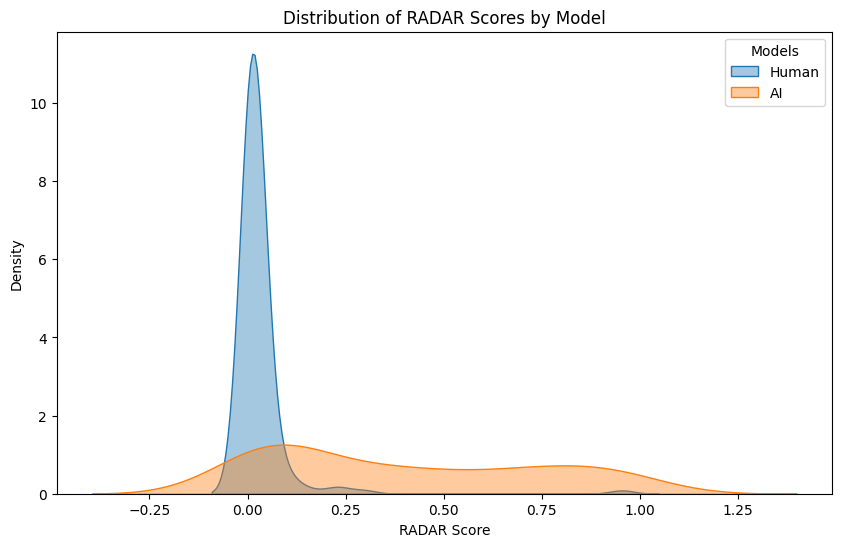

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Density")
plt.title("Distribution of RADAR Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

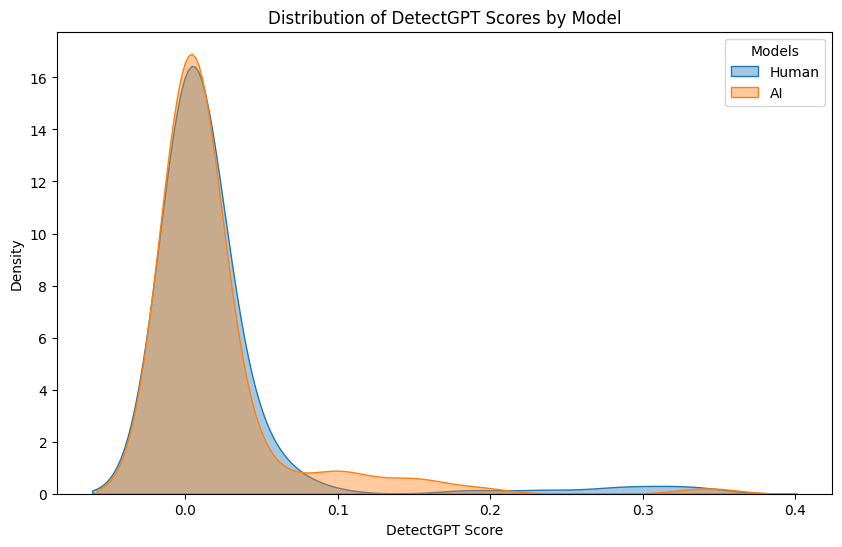

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

# Plot KDE for smooth distributions
plt.figure(figsize=(10, 6))
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    sns.kdeplot(subset[score_col].dropna(), label=model, fill=True, alpha=0.4)  # Fill for better visibility

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Density")
plt.title("Distribution of DetectGPT Scores by Model")
plt.legend(title="Models")

# Show plot
plt.show()

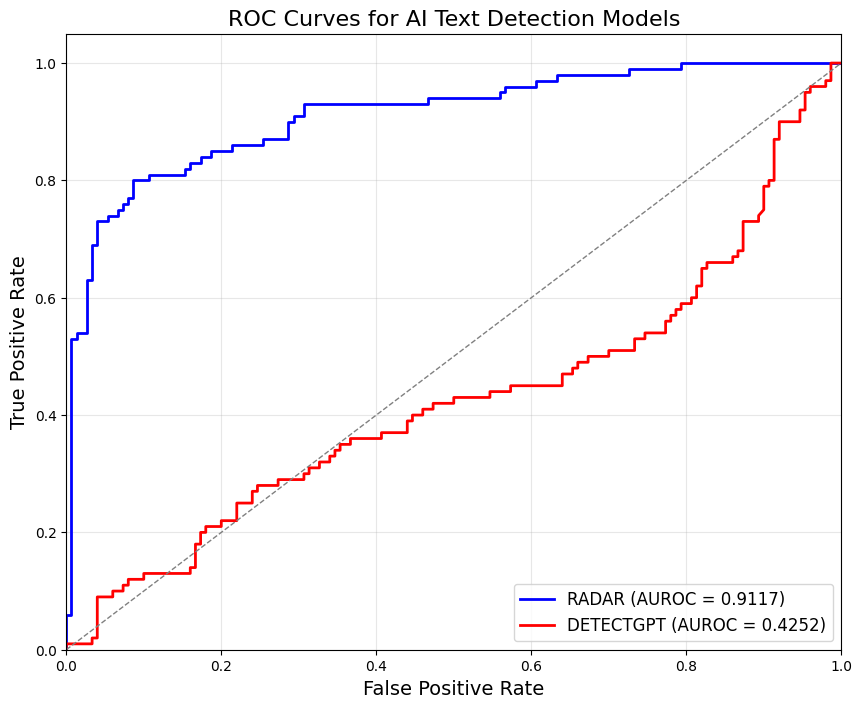

In [60]:
from sklearn.metrics import roc_curve

# Calculate ROC curve points for both detectors
fpr_radar, tpr_radar, _ = roc_curve(combined_df['label'], combined_df['radar_score'])
fpr_wild, tpr_wild, _ = roc_curve(combined_df['label'], combined_df['detectgpt_score'])

# Create a figure with appropriate size
plt.figure(figsize=(10, 8))

# Plot both ROC curves
plt.plot(fpr_radar, tpr_radar, color='blue', lw=2,
         label=f'RADAR (AUROC = {auroc_radar:.4f})')
plt.plot(fpr_wild, tpr_wild, color='red', lw=2,
         label=f'DETECTGPT (AUROC = {auroc_detectgpt:.4f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Add labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for AI Text Detection Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

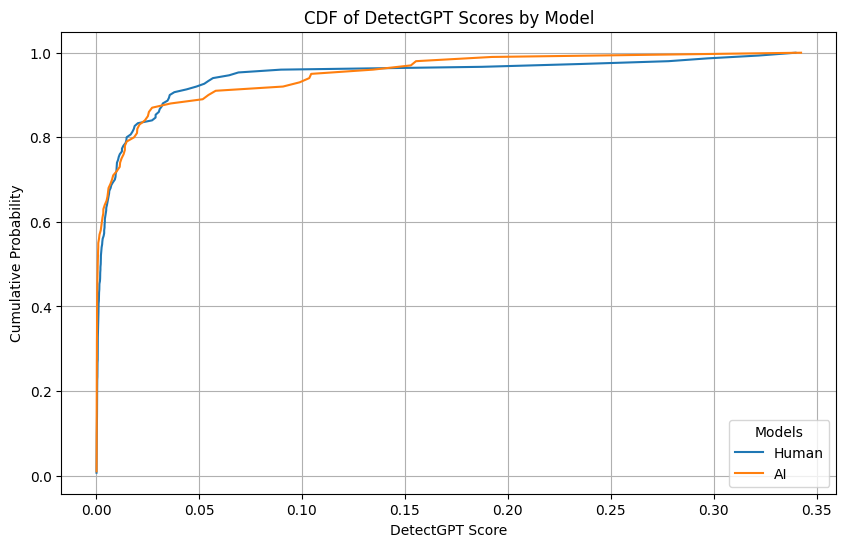

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "detectgpt_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("DetectGPT Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of DetectGPT Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()

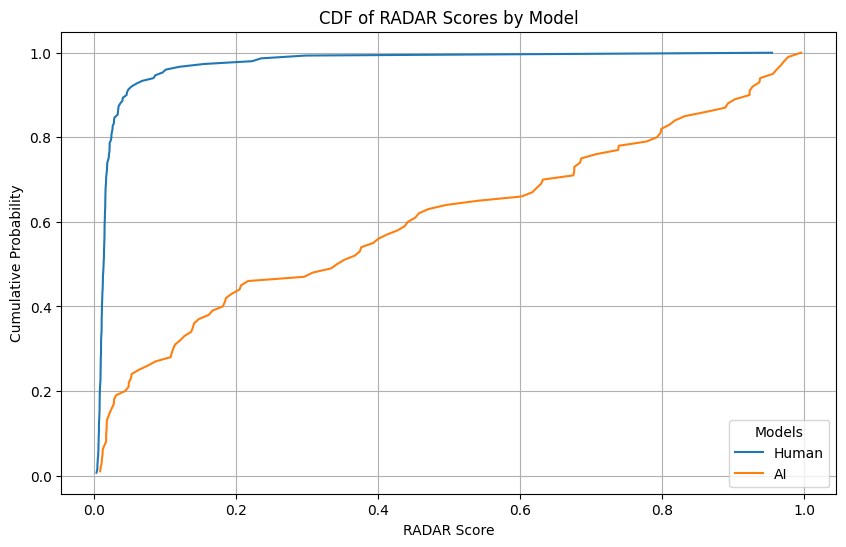

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_col = "source"
score_col = "radar_score"

models = combined_df[model_col].unique()

plt.figure(figsize=(10, 6))

# Loop through Human and AI separately
for model in models:
    subset = combined_df[combined_df[model_col] == model]
    scores = subset[score_col].dropna()
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores)+1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label=model)

# Add labels and title
plt.xlabel("RADAR Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of RADAR Scores by Model")
plt.legend(title="Models")
plt.grid(True)
plt.show()